In [1]:
# Import the dataset to train on
import torch
import einops
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import utils as utils

### Load Training and Testing Data

Pytorch offers a convenient way to fetch training data sets online via the torchvision.datasets package. Here we fetch a large set of 60,000 labeled training images and 10,000 labeled testing images. The images are 28x28 pixels and are of fashion items.

In [2]:
def get_mnist(batch_size=64, shuffle=True):
    """
    Download the MNIST dataset and return DataLoaders for training and testing.

    Args:
        batch_size (int): Number of samples per batch in the DataLoader.
        shuffle (bool): Whether to shuffle the dataset in the DataLoader.

    Returns:
        tuple: Training and testing DataLoaders.
    """
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] range
    ])

    # Download the MNIST dataset
    train_dataset = datasets.FashionMNIST(
        root="./data",
        train=True,
        transform=transform,
        download=True
    )
    test_dataset = datasets.FashionMNIST(
        root="./data",
        train=False,
        transform=transform,
        download=True
    )

    # Create DataLoaders for the datasets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader


### Inspect Training Data Batch
A batch of training data is examined. Note that image processing (normalization) has been added to the data loading process, creating a higher contrast in the images.

images tensor is torch.Size([64, 1, 28, 28])


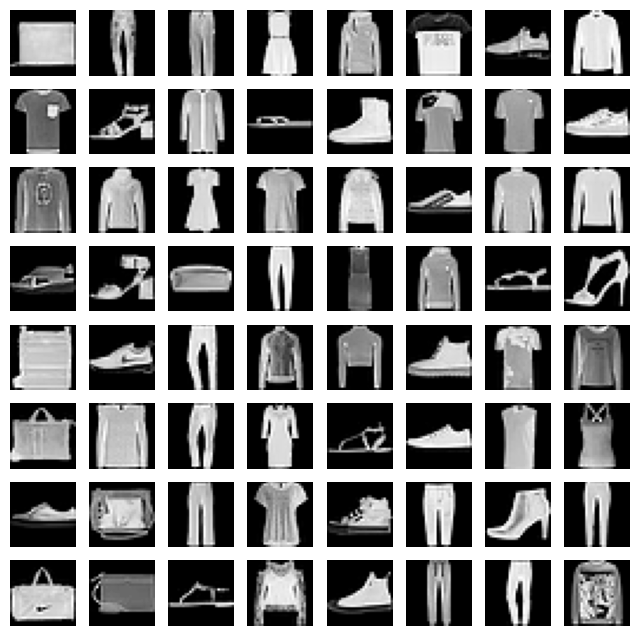

In [3]:
train_loader, test_loader = get_mnist(batch_size=64, shuffle=True)
utils.show_first_batch(train_loader)

### Define and Train a Simple Model to Approximate a Velocity Flow Field

The objective is to approximate a time-dependent velocity field that forms a map between images of pure noise and images from the dataset. We effectively learn some function $\dot x = y(x,t ; \theta)$ where $x$ is the current image, $t$ is some time between pure noise and nice images, and $\theta$ are the parameters of the approximating function $y$. In practice a neural network using covolutions and a Unet structure is used to "learn" $y$ from the data. Below is a training loop to learn the time dependent velocity field.

In [4]:
from unet2d import Unet2D
from tqdm import tqdm
import persistence as mdl
import os

In [16]:
def train(model: Unet2D, dataloader, num_epochs=5, optimizer=None, device='cuda'):
    if optimizer is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        # Set learning rate scheduler

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.96) 
    model.train()

    for epoch in range(num_epochs):
        running_loss = 0
        progress = tqdm(
            enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch + 1}/{num_epochs}"
        )
        for i, data in progress:
            # Gather interpolated samples and velocities
            X1, labels = data
            X1 = X1.to(device)
            X0 = torch.randn_like(X1).to(device)
            T = torch.rand(X1.size(0)).to(device)
            T_expanded = T.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1) 
            
            XT = (1 - T_expanded) * X0 + T_expanded * X1
            BT = X1 - X0

            # Predict the correct velocities with time embedding
            optimizer.zero_grad()
            B_hat_T = model(XT, T)
            # Compute the loss
            loss = torch.mean((BT - B_hat_T) ** 2) / torch.mean(BT ** 2)

            loss.backward()
            # Gradient clipping for DNN
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()                
            # Update progress bar with the current average loss
            progress.set_postfix(loss=running_loss / (i + 1), lr=optimizer.param_groups[0]['lr'])
        
        scheduler.step()
            
        if epoch % 10 == 0: 
            # save model at end of train    
            cur_dir = os.getcwd()
            save_path = os.path.join(cur_dir, f"unet_{num_epochs}epochs.pth")    
            mdl.save_model(model, save_path)

In [17]:
model_params = {
    'dim'              : 64,             # Base number of hidden channels in model
    'dim_mults'        : (1, 2,2),      # Multipliers for hidden dims in each superblock, total 2x downsamples = len(dim_mults)-1
    'data_channels'    : 1,              # Data clamped down to 22 channels -1 to 20, with -1 "sky/air" category
    'dropout'          : 0.,              # Optional network dropout
    'self_condition'   : False,           # Optional conditioning on input data
    'time_resolution'  : 128,             # Resolution of time (number of random Fourier features)        
    'time_bandwidth'   : 1000.,            # Starting bandwidth of fourier frequencies, f ~ N(0, time_bandwidth)
    'time_learned_emb' : True,            # Learnable fourier freqs and phases

    'attn_enabled'     : False,            # Enable or disable self attention before each (down/up sample) also feeds skip connections 
    'attn_dim_head'    : 32,              # Size of attention hidden dimension heads
    'attn_heads'       : 4,               # Number of chunks to split hidden dimension into for attention
    'full_attn'        : None,            # defaults to full attention only for inner most layer final down, middle, first up
    'flash_attn'       : False            # For high performance GPUs https://github.com/Dao-AILab/flash-attention
}     

# Create a U-Net model
model = Unet2D(**model_params)
model.to('cuda:0')

train(model, train_loader, num_epochs = 11, device='cuda:0')


Epoch 11/11: 100%|██████████| 938/938 [01:16<00:00, 12.32it/s, loss=0.135, lr=0.000665]


### Load Model and Generate
With the model trained we can load its weights and generate images from pure noise via ODE integration.

In [18]:
model = Unet2D(**model_params)
model = mdl.load_model(model, "./unet_11epochs.pth",device='cpu')

Loaded model from ./unet_11epochs.pth


In [19]:
def euler_integrate(dxdt, x0, t_start, t_end, num_steps):

    dt = (t_end - t_start) / num_steps
    t = torch.linspace(t_start, t_end, num_steps, device=x0.device)
    x = x0

    # Store the trajectory
    trajectory = [x0]
    for i in range(num_steps - 1):
        ti = t[i].unsqueeze(0)
        dx = dxdt(x, ti) * dt
        x = x + dx  # Euler step
        trajectory.append(x)

    return torch.stack(trajectory, dim=0)

images tensor is torch.Size([4, 1, 28, 28])


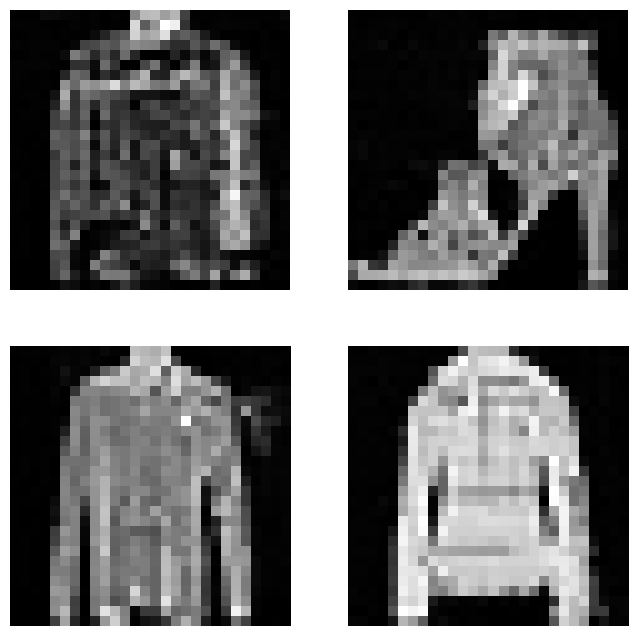

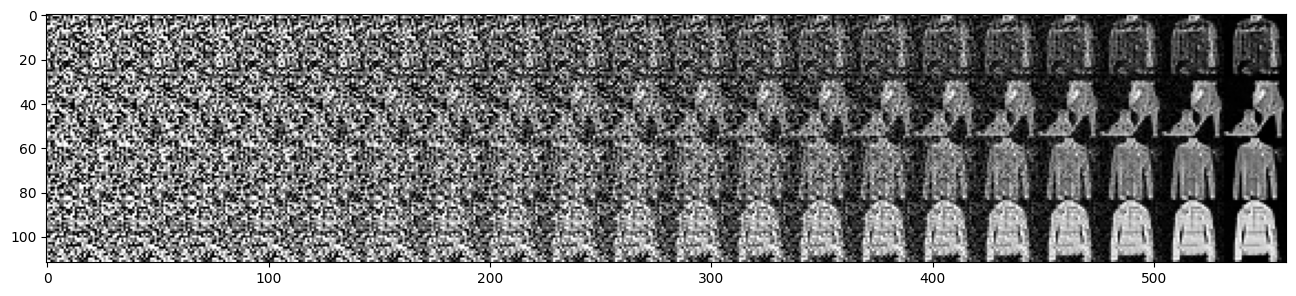

In [24]:
def dxdt(x,t):
    return model(x, t)

# Integrate the learned dynamics from t =0 to t=1 with initial condition x0
X0 = torch.randn(4,1,28,28)
Xint = euler_integrate(dxdt, X0, 0, 1, 20)

final_frame = Xint[-1].detach()
utils.show_images(final_frame, denormalize=True)
utils.show_time_series(Xint, denormalize=True)

generated_images = Xint.detach().cpu().numpy()


# utils.animate_batch(generated_images, fps=10)







